In [2]:
from os.path import join
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.metrics import r2_score, mean_squared_error
plt.style.use("fivethirtyeight")
pd.set_option('display.max_columns', 100)
%matplotlib inline

### Load and combine data
- Insert zeros as needed to match other files*** i.e. 1033 --> 01033

In [8]:
target_crop = "soybean"
repo_data_dir = "../data/"
image_dir = "../images/"
local_data_dir = '/Users/adamszabunio/Desktop/NASS_raw_data/{}/'.format(target_crop)
soy_yields = pd.read_csv(join(local_data_dir, 'soybean_historical_yields_1995_2017.csv'), index_col=0)
soy_yields2 = pd.read_csv(join(local_data_dir, 'soybean_historical_yields_1970_1994.csv'), index_col=0)
soy_yields = soy_yields.append(soy_y2)
soy_yields.reset_index(inplace=True, drop=True)
soy_yields.fips_code = soy_yields.fips_code.astype(str).apply(lambda x: x.zfill(5))

print("Shape:", soy_yields.shape)
soy_yields.head()

Shape: (78815, 7)


,fips_code,state_alpha,year,nassyield,county_name,asd_desc,location_desc
0,01033,AL,2017,48.2,COLBERT,NORTHERN VALLEY,"ALABAMA, NORTHERN VALLEY, COLBERT"
1,01033,AL,2016,31.2,COLBERT,NORTHERN VALLEY,"ALABAMA, NORTHERN VALLEY, COLBERT"
2,01033,AL,2015,44.1,COLBERT,NORTHERN VALLEY,"ALABAMA, NORTHERN VALLEY, COLBERT"
3,01033,AL,2014,44.0,COLBERT,NORTHERN VALLEY,"ALABAMA, NORTHERN VALLEY, COLBERT"
4,01033,AL,2013,44.2,COLBERT,NORTHERN VALLEY,"ALABAMA, NORTHERN VALLEY, COLBERT"


### Exploratory Data Analysis
- Similar to the [CORN dataset](corn_EDA.ipynb), the fips code changes for "STE GENEVIEVE" County in 1986

In [30]:
s = soy_yields[soy_yields.fips_code.isin(['29193', '29186'])]
s.loc[[62047,61996]]

,fips_code,state_alpha,year,nassyield,county_name,asd_desc,location_desc
62047,29193,MO,1986,31.9,STE. GENEVIEVE,EAST,"MISSOURI, EAST, STE. GENEVIEVE"
61996,29186,MO,1987,36.7,STE GENEVIEVE,EAST,"MISSOURI, EAST, STE GENEVIEVE"


In [31]:
s.groupby(["fips_code", "county_name"]).year.count()

fips_code  county_name   
29186      STE GENEVIEVE     31
29193      STE. GENEVIEVE    17
Name: year, dtype: int64

### Again, replace the old fips code with the newest
- This resolves a merge error when merging with county centroids 

In [41]:
soy_yields["fips_code"].replace(to_replace='29193', value='29186', inplace=True)

### No yields <= 0

In [68]:
soy_yields.nassyield.apply(lambda x: x<=0).sum()

0

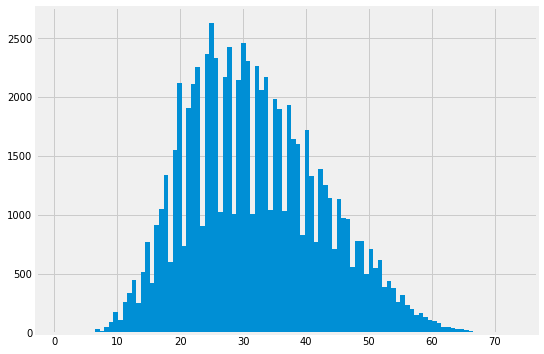

In [101]:
soy_yields.nassyield.hist(bins=100, figsize=(8,6));

In [42]:
ts_df = soy_yields.pivot(index='fips_code', columns='year', values='nassyield')
ts_df

year,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
fips_code,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
01001,25.0,27.0,18.2,17.6,20.0,15.9,22.9,30.0,14.0,21.6,11.8,19.2,22.6,19.4,24.4,23.8,22.8,15.3,24.2,15.2,12.3,17.8,NaN,NaN,NaN,NaN,NaN,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.0,16.9,26.0,NaN,41.2,NaN,NaN,NaN,NaN
01003,27.0,27.0,20.4,25.9,26.0,27.0,30.0,21.1,23.0,17.5,24.6,25.7,26.5,30.2,26.0,24.8,25.6,25.0,27.7,22.0,19.0,25.9,30.0,30.1,28.6,29.0,35.0,25.0,22.0,28.0,20.0,34.0,27.0,31.0,31.0,NaN,38.0,38.0,41.5,40.5,40.0,37.0,41.0,41.9,43.8,43.4,41.8,42.0
01005,23.0,26.0,12.1,19.1,28.0,19.0,18.9,20.9,21.5,28.5,15.3,20.9,27.5,19.3,18.1,26.7,18.0,18.0,25.0,22.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.1,NaN,NaN
01007,21.0,25.0,20.8,17.8,24.0,22.1,27.0,22.1,22.0,26.9,19.5,24.3,25.3,17.9,22.9,22.3,19.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01009,24.0,25.0,19.8,16.6,26.0,30.0,32.0,20.0,28.0,29.5,14.4,25.1,30.5,15.9,18.4,29.7,26.5,19.0,25.1,27.3,16.8,25.0,35.0,28.2,43.5,21.0,37.0,28.0,20.0,20.0,20.0,35.0,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.6,NaN,41.4,49.7,33.9,43.8,25.0,48.6
01011,24.0,25.0,20.3,22.3,21.0,21.0,20.0,20.0,22.0,26.4,12.2,20.9,23.0,22.3,21.8,26.1,21.0,16.5,18.4,16.9,16.7,19.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.2,36.5,NaN,NaN,NaN
01013,21.0,26.0,12.6,20.1,23.0,20.0,20.0,15.0,20.0,24.1,11.8,23.1,24.0,17.7,24.0,25.3,32.1,15.6,24.2,16.1,16.5,23.9,28.0,24.0,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01015,23.0,25.0,21.1,19.2,22.0,23.0,24.0,25.3,21.0,26.8,14.1,23.1,21.5,18.4,22.6,32.1,24.0,15.0,23.3,23.0,18.2,23.8,35.7,19.7,39.0,23.0,35.0,27.0,25.0,18.0,15.0,35.0,21.0,41.0,39.0,31.0,18.0,18.0,NaN,38.0,17.1,28.2,36.1,44.2,34.0,NaN,NaN,NaN
01017,21.0,23.0,18.7,23.0,19.0,25.0,21.0,16.0,16.0,NaN,15.7,19.2,24.4,21.1,18.1,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
ts_df.describe()

year,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
count,1450.000000,1446.000000,1715.000000,1752.000000,1810.000000,1784.000000,1781.000000,1829.000000,1848.000000,1872.000000,1856.000000,1822.000000,1798.000000,1856.000000,1861.000000,1840.000000,1802.000000,1764.000000,1799.000000,1810.000000,1756.000000,1721.000000,1721.000000,1658.000000,1639.000000,1599.000000,1609.000000,1660.000000,1660.000000,1609.000000,1637.000000,1621.00000,1603.000000,1597.000000,1650.000000,1622.000000,1583.000000,1509.000000,1306.000000,1382.000000,1496.000000,1419.000000,1455.000000,1367.000000,1430.000000,1306.000000,1352.000000,1353.000000
mean,24.025517,25.230567,24.534111,24.653082,22.514641,25.463397,23.341606,27.033461,26.040152,29.339476,23.000808,27.825576,28.933593,23.650593,26.371843,30.378533,29.079911,29.319785,25.704669,29.213591,29.812130,31.402673,33.414178,29.660676,37.505247,31.660851,34.693163,34.255542,33.049277,31.231075,33.776176,35.78322,32.730069,33.575329,39.315636,38.249630,38.453001,36.376143,37.295942,41.890738,39.705682,38.943058,39.311478,42.530944,45.242098,44.996248,47.586760,47.423577
std,5.828479,5.894049,6.494447,5.224763,4.549158,5.705164,6.693615,7.478861,7.032220,5.602669,9.500465,7.582111,6.551290,7.628066,7.079226,7.449904,8.735822,8.931632,6.209811,7.664095,9.891195,8.114678,7.820376,9.409994,7.886519,8.615471,7.139126,8.951279,11.024377,10.745667,10.725772,8.91073,10.270704,7.940000,9.600980,10.230961,11.059988,11.886812,8.296603,8.963216,11.125876,10.975471,10.201738,9.331013,9.397023,10.582468,11.377938,9.351310
min,9.000000,10.000000,9.500000,8.000000,5.500000,10.500000,5.000000,10.000000,8.000000,13.000000,6.300000,8.600000,10.500000,8.400000,7.900000,8.000000,1.700000,7.000000,4.000000,6.000000,5.400000,3.000000,7.000000,5.000000,10.000000,8.600000,12.500000,11.300000,9.200000,6.000000,8.000000,8.40000,6.000000,2.900000,7.000000,0.700000,5.000000,7.000000,12.000000,9.500000,9.000000,5.100000,3.600000,13.700000,17.600000,13.800000,8.200000,11.500000
25%,20.000000,22.000000,20.000000,21.000000,19.500000,21.600000,18.000000,21.000000,20.800000,25.000000,14.800000,22.200000,24.500000,17.500000,21.500000,25.000000,22.000000,22.000000,22.000000,24.000000,21.975000,25.500000,28.000000,22.000000,32.000000,25.000000,30.000000,27.875000,24.000000,22.000000,25.900000,30.00000,25.000000,28.400000,33.000000,30.925000,30.950000,27.200000,31.500000,36.500000,31.100000,32.000000,33.400000,36.350000,38.700000,37.400000,39.800000,41.500000
50%,24.000000,25.000000,24.000000,24.000000,22.600000,24.950000,23.000000,26.000000,25.900000,29.000000,22.000000,27.000000,28.800000,22.500000,26.400000,30.000000,29.500000,29.650000,25.700000,29.150000,31.000000,31.000000,33.800000,30.000000,37.000000,31.100000,34.700000,34.500000,33.400000,30.500000,35.800000,36.00000,32.000000,34.000000,40.000000,38.800000,40.000000,37.000000,37.000000,42.500000,41.400000,40.000000,40.500000,43.500000,46.100000,46.350000,49.100000,48.300000
75%,28.000000,29.000000,29.000000,28.000000,25.500000,28.700000,28.000000,33.000000,31.000000,33.000000,31.000000,33.000000,33.500000,29.300000,31.100000,35.800000,36.000000,36.200000,29.300000,34.900000,37.900000,37.000000,39.100000,37.000000,43.000000,38.100000,40.000000,41.000000,42.000000,40.000000,42.000000,42.00000,40.000000,39.000000,46.500000,46.000000,47.000000,46.100000,43.000000,48.000000,48.600000,46.300000,46.700000,49.500000,52.300000,52.975000,56.200000,54.200000
max,40.000000,41.000000,42.000000,40.000000,40.000000,43.000000,40.500000,44.700000,43.800000,45.000000,45.800000,49.300000,45.000000,43.300000,47.300000,52.500000,48.500000,50.800000,50.000000,49.000000,55.700000,56.000000,53.000000,54.800000,59.000000,53.500000,58.000000,57.000000,58.000000,60.000000,58.000000,59.00000,61.800000,64.400000,60.

In [61]:
ts_df.to_csv(join(repo_data_dir, "ts_{}_df.csv".format(target_crop)))

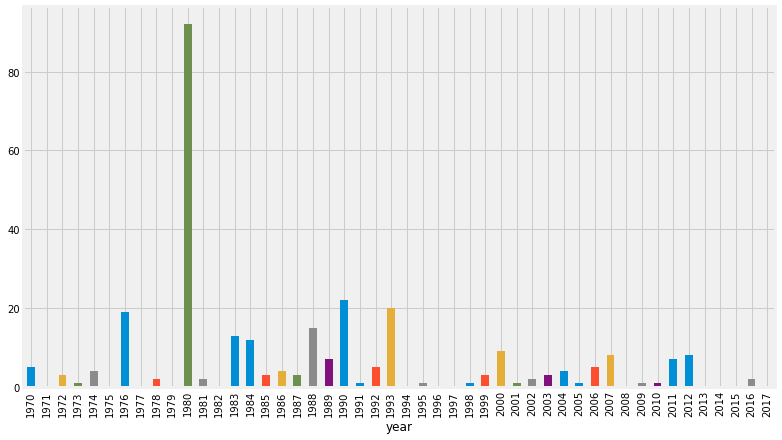

In [79]:
ts_df.applymap(lambda x: x<10).sum().plot(kind='bar', figsize=(12,7));

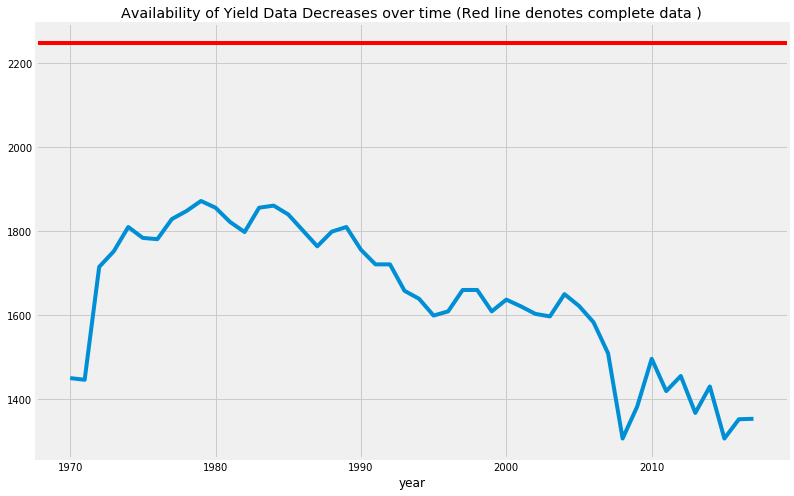

In [86]:
fig, ax = plt.subplots(figsize=(12,8))
plt.axhline(y=ts_df.shape[0], color='r', linestyle='-')
plt.title("Availability of Yield Data Decreases over time (Red line denotes complete data )")
ts_df.count().plot();

# Nearly 70% of counties have at least 30 years (consecutive years not a requirement)

In [108]:
a = pd.DataFrame({"year_count":ts_df.T.count()})

a[a.year_count>=30].count()[0]/a.shape[0]

0.6970640569395018

# 28.6% of Soybean data is Complete

In [153]:
counties, years = ts_df.shape
complete_data = ts_df.T.count().value_counts()[years]
percent_complete = round(complete_data/counties *100, 2)
complete_data, counties, percent_complete

(643, 2248, 28.6)

### Save Full Data for Training

In [109]:
full_data = ts_df[ts_df.index.isin(a[a.year_count==years].index.values)]
full_data.head()

year,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
fips_code,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
01049,23.0,27.0,22.2,18.6,21.0,23.0,23.0,20.0,24.0,29.3,14.0,23.9,23.4,17.1,22.5,29.0,18.0,17.0,25.0,26.8,21.9,22.0,32.8,24.7,37.1,25.0,36.0,26.0,20.0,15.0,25.0,38.0,19.0,39.0,39.0,40.0,20.0,17.0,25.5,38.0,23.3,30.0,47.0,47.9,44.3,45.6,29.2,46.1
01077,22.0,29.0,24.4,19.7,20.0,26.5,22.0,18.0,17.9,24.5,14.0,22.8,27.6,18.6,15.7,32.2,21.8,16.5,17.7,21.0,13.6,25.0,30.5,23.9,27.2,27.0,36.0,27.0,27.0,6.0,9.0,38.0,25.0,37.0,31.0,28.0,24.0,18.0,26.5,39.5,24.5,31.0,46.4,40.1,37.5,46.5,29.9,46.3
01083,22.0,29.0,22.5,24.0,22.0,30.0,26.0,19.9,21.0,27.2,17.9,25.5,29.2,15.5,21.0,32.5,25.0,13.0,23.1,23.2,15.7,26.5,29.9,28.2,32.6,24.0,36.0,30.0,22.0,8.0,17.0,35.0,25.0,39.0,40.0,31.0,16.0,18.0,34.0,44.5,26.0,38.0,48.4,45.0,37.8,47.4,31.8,50.3
01089,21.0,24.0,19.7,18.3,20.0,24.0,22.0,21.0,22.0,26.3,14.0,23.3,28.3,14.7,22.5,29.8,29.0,17.0,24.2,22.3,22.0,28.2,31.0,25.6,36.3,24.0,37.0,27.0,22.0,12.0,20.0,34.0,23.0,36.0,35.0,31.0,16.0,21.0,38.5,42.0,22.6,34.5,46.3,43.6,42.7,45.8,37.6,42.4
05001,26.0,29.0,25.0,29.0,27.0,31.0,27.2,27.6,28.0,31.0,19.0,30.0,29.0,26.0,28.0,30.0,30.0,30.0,32.0,28.0,33.0,34.1,35.0,32.2,38.6,33.0,37.0,38.7,30.4,41.0,35.0,40.0,42.0,45.0,46.0,41.0,46.0,46.0,42.0,45.0,43.2,44.3,50.7,51.8,55.1,53.9,54.4,53.7


In [113]:
full_data.to_csv(join(repo_data_dir, "ts_{}_47yr_df.csv".format(target_crop)))

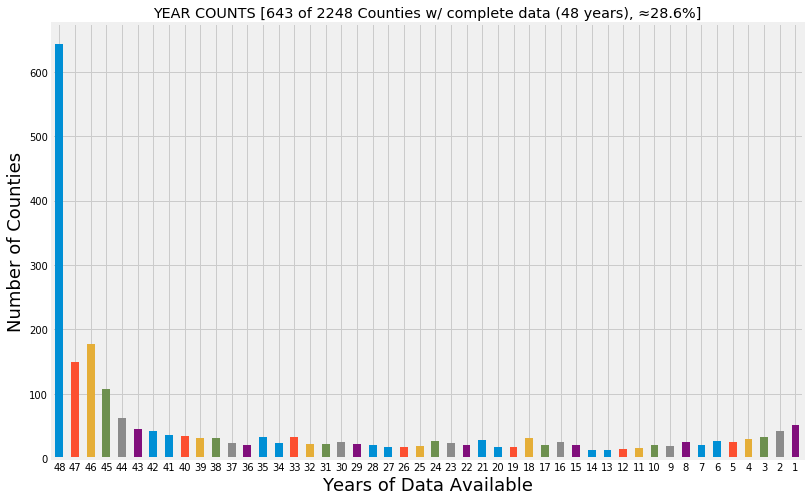

In [193]:
fig, ax= plt.subplots(figsize=(12, 8))
reverse_count = ts_df.T.count().value_counts().sort_index(ascending=False)

reverse_count.plot(kind="bar", rot=0)
plt.title("YEAR COUNTS [{} of {} Counties w/ complete data ({} years), ≈{}%]".format(
                                complete_data, counties, years, percent_complete))
plt.ylabel("Number of Counties", fontsize=18)
plt.xlabel("Years of Data Available", fontsize=18);
fig.savefig(join(image_dir, "{}_year_counts".format(target_crop)))

#  TODO: Plots 
### Corn and Soybean together
- Year Counts (as percentage)
- Cumulative Sums
- Num counties per state

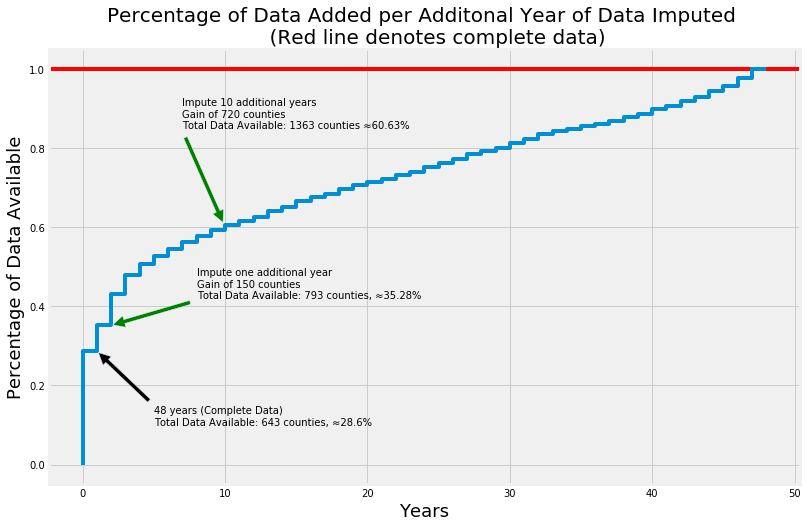

In [223]:
cumulative_sum = reverse_count.cumsum()
cumulative_percent = (cum_sum/counties).values.tolist()
cumulative_percent.insert(0,0)

fig, ax = plt.subplots(figsize=(12,8))
plt.axhline(y=1, color='r', linestyle='-')
plt.title("""Percentage of Data Added per Additonal Year of Data Imputed 
    (Red line denotes complete data)""", fontsize=20)
plt.xlabel("Years", fontsize=18)
plt.ylabel("Percentage of Data Available", fontsize=18) 
plt.annotate('{} years (Complete Data) \nTotal Data Available: {} counties, ≈{}%'.format(
             years, complete_data, percent_complete),
             xy=(0.9, .29), xytext=(5, .10),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate("""
Impute one additional year 
Gain of {} counties 
Total Data Available: {} counties, ≈{:.2f}%""".format(
    reverse_count[years-1], cumulative_sum[years-1],
    cumulative_sum[years-1]/counties *100
    ),
    xy=(1.8, .35), xytext=(8, .42), 
    arrowprops=dict(facecolor='green', shrink=0.05)
)
plt.annotate("""
Impute 10 additional years 
Gain of {} counties 
Total Data Available: {} counties ≈{:.2f}%""".format(
    cumulative_sum[years-10] - cumulative_sum[years], 
    cumulative_sum[years-10],
    cumulative_sum[years-10]/counties *100), 
    xy=(10, .6), xytext=(7, .85), 
    arrowprops=dict(facecolor='green', shrink=0.05))
plt.step(np.arange(0, years+1), cumulative_percent);
fig.savefig(join(image_dir, "{}_cumulative_sum".format(target_crop)))

# Everything Below is a copy of "corn_EDA.ipynb"

# States w/ Complete Data

In [37]:
complete_data = corn_yields[corn_yields.fips_code.isin(a[a.year_count==47].index.values)]

complete_data['state_alpha'].unique()

array(['AL', 'AR', 'CA', 'CO', 'DE', 'GA', 'IL', 'IN', 'IA', 'KS', 'KY',
       'LA', 'MD', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NJ', 'NC', 'ND',
       'OH', 'PA', 'SC', 'SD', 'TN', 'TX', 'VA', 'WV', 'WI', 'WY'], dtype=object)

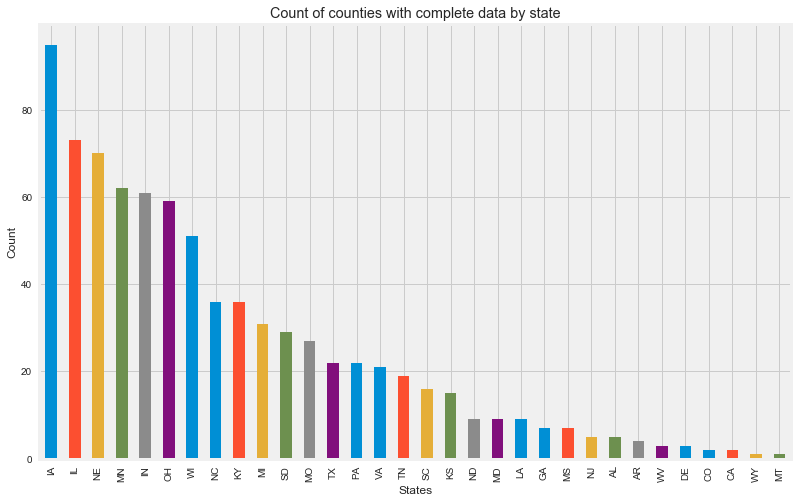

In [38]:
complete_data_states = complete_data['state_alpha'].value_counts()/47
ax = complete_data_states.plot(kind='bar', figsize=(12,8), title="Count of counties with complete data by state")
ax.set(xlabel='States', ylabel='Count');

# How's Iowa looking?

In [39]:
len(corn_yields[['state_alpha','fips_code']][corn_yields.state_alpha == 'IA']['fips_code'].unique())

99

In [40]:
missing_IA_df = corn_yields[~corn_yields.fips_code.isin(a[a.year_count==47].index.values)]
findIA_df = missing_IA_df[missing_IA_df.state_alpha == 'IA'].pivot(index='fips_code', columns='year', values='nassyield')
findIA_df

year,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2016
fips_code,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
19129,81.6,93.0,113.7,108.3,51.7,79.1,95.4,56.3,107.0,122.3,99.0,117.0,103.1,90.0,98.2,128.6,130.2,126.7,107.7,109.4,120.5,131.9,156.0,75.0,147.4,105.9,133.2,135.8,123.7,128.2,135.2,132.5,110.3,131.6,184.8,163.7,159.5,147.4,156.0,191.2,160.2,155.0,128.8,171.0,184.9,188.4
19135,79.0,90.8,103.6,86.9,60.1,72.4,91.8,45.0,90.0,107.1,94.3,114.5,78.6,29.8,91.6,114.5,112.8,107.3,46.6,94.5,112.9,107.2,117.3,61.5,149.0,84.1,112.8,127.2,111.9,110.8,135.8,115.9,158.0,129.6,171.3,154.3,137.0,161.3,136.0,156.3,77.4,112.5,67.3,115.3,175.7,180.0
19173,67.7,92.6,104.5,98.5,32.5,55.0,83.2,65.8,88.7,109.0,65.4,115.0,82.3,44.6,60.6,122.1,115.3,109.5,60.0,95.5,96.6,118.1,127.8,61.6,135.9,65.2,112.8,117.4,119.2,115.6,140.7,114.9,126.6,116.4,157.9,156.8,142.4,137.6,135.0,150.2,122.2,140.5,91.7,136.2,178.8,159.9
19175,77.5,90.8,102.3,96.9,44.6,63.5,94.5,40.3,92.5,108.8,80.7,116.6,90.4,64.0,81.5,125.4,108.5,115.9,67.3,103.0,111.0,124.8,130.0,53.3,143.8,71.8,120.7,117.4,129.7,140.8,136.5,127.3,142.2,106.7,160.4,157.2,153.6,154.1,148.0,153.8,113.2,132.6,87.3,137.0,176.1,183.0


In [41]:
years_set = {i for i in range(1970, 2017)}
years_set.difference(set(findIA_df.columns))

{2015}

# All 4 IOWA counties w/ missing data are missing only one year: 2015

In [42]:
colsIA = [col for col in ts_df.T.columns if str(col).startswith('19')]
pd.DataFrame(ts_df.T.reindex(index=ts_df.T.index[::-1])[colsIA].loc[2015]).T

fips_code,19001,19003,19005,19007,19009,19011,19013,19015,19017,19019,19021,19023,19025,19027,19029,19031,19033,19035,19037,19039,19041,19043,19045,19047,19049,19051,19053,19055,19057,19059,19061,19063,19065,19067,19069,19071,19073,19075,19077,19079,19081,19083,19085,19087,19089,19091,19093,19095,19097,19099,19101,19103,19105,19107,19109,19111,19113,19115,19117,19119,19121,19123,19125,19127,19129,19131,19133,19135,19137,19139,19141,19143,19145,19147,19149,19151,19153,19155,19157,19159,19161,19163,19165,19167,19169,19171,19173,19175,19177,19179,19181,19183,19185,19187,19189,19191,19193,19195,19197
2015,176.5,169.6,175.4,154.3,189.8,187.5,192.9,192.3,203.1,191.6,202.7,193.3,194.7,195.4,193.7,188.8,196.9,209.6,202.8,152.4,202.8,193.2,188.2,199.1,182.4,142.4,162.7,195.8,176.0,194.5,197.0,203.3,191.8,196.5,200.2,179.9,189.0,199.9,179.2,198.1,201.2,199.3,189.5,178.4,202.1,194.8,203.1,199.3,190.6,198.9,168.2,187.1,186.6,181.0,199.0,145.1,189.2,181.7,154.8,196.0,169.6,190.3,178.1,194.9,NaN,202.1,169.0,NaN,185.2,177.7,205.2,204.7,165.8,197.5,203.6,205.5,187.0,204.0,197.8,147.8,204.8,195.9,195.3,201.9,188.0,189.5,NaN,NaN,158.3,159.3,170.3,195.0,158.0,201.0,203.6,185.6,202.3,202.1,198.4


In [43]:
len(colsIA) *47

4653

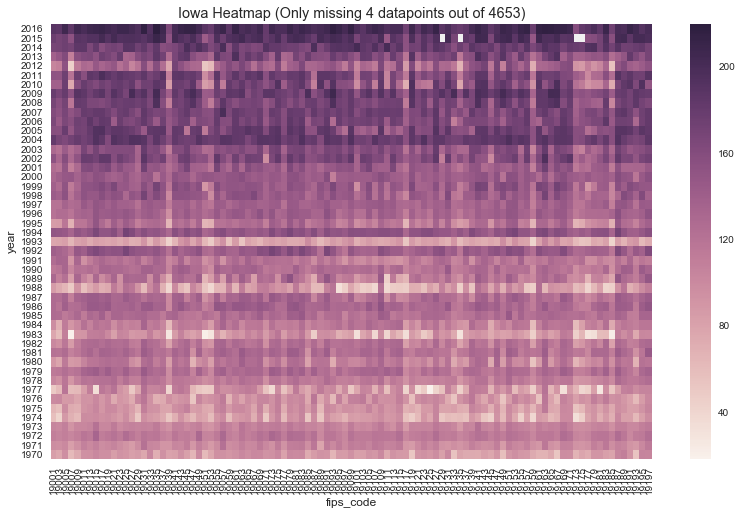

In [45]:
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(ts_df.T.reindex(index=ts_df.T.index[::-1])[colsIA])
ax.set_title("Iowa Heatmap (Only missing 4 datapoints out of 4653)");
fig.savefig("images/IA_heatmap")

# Heatmap for Alabama

In [46]:
colsAL = [col for col in ts_df.T.columns if str(col).startswith('01')]

AL_counts = a[a.T.columns.isin(colsAL)]["year_count"].sum()
AL_total = len(colsAL)*47
print(AL_counts, AL_total, "missing:", AL_total-AL_counts)
1 - AL_counts/AL_total

2407 3149 missing: 742


0.23563035884407746

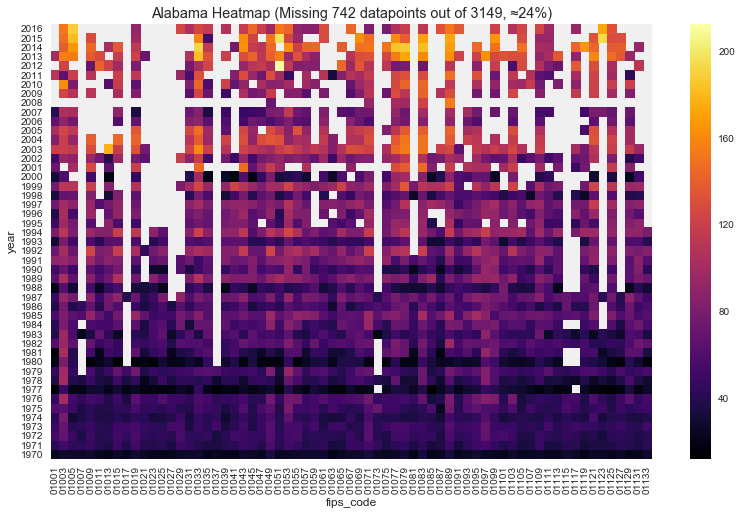

In [47]:
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(ts_df.T.reindex(index=ts_df.T.index[::-1])[colsAL], cmap="inferno")
ax.set_title("Alabama Heatmap (Missing 742 datapoints out of 3149, ≈24%)");
fig.savefig("images/AL_heatmap")

# Heatmap for California

In [48]:
colsCA = [col for col in ts_df.T.columns if str(col).startswith('06')]

CA_counts = a[a.T.columns.isin(colsCA)]["year_count"].sum()
CA_total = len(colsCA)*47
print(CA_counts, CA_total, "missing:", CA_total-CA_counts)
1 - CA_counts/CA_total

985 2068 missing: 1083


0.52369439071566726

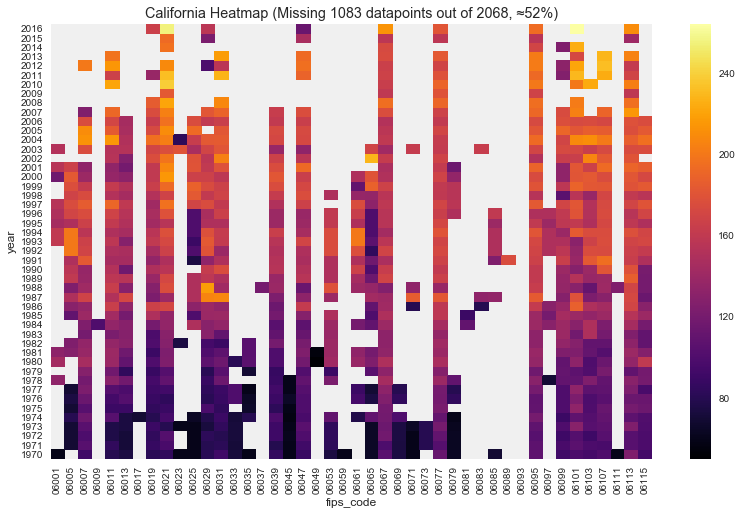

In [49]:
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(ts_df.T.reindex(index=ts_df.T.index[::-1])[colsCA], cmap="inferno")
ax.set_title("California Heatmap (Missing 1083 datapoints out of 2068, ≈52%)");
fig.savefig("images/CA_heatmap")

# Heatmap of all data

In [50]:
total_counts = a.year_count.sum()
total_total = len(a) *47
print(total_counts, total_total, "missing:", total_total-total_counts)
1 - total_counts/total_total

98790 130096 missing: 31306


0.24063768294182752

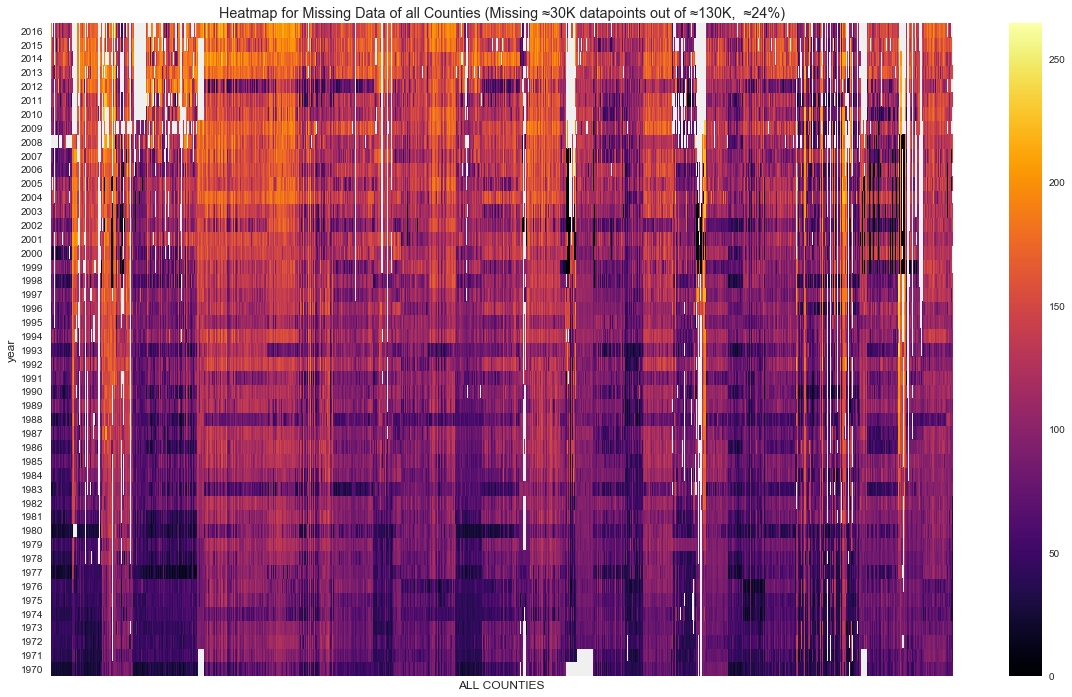

In [28]:
fig, ax = plt.subplots(figsize=(18, 12))
sns.heatmap(ts_df.T.reindex(index=ts_df.T.index[::-1]), cmap="inferno")
plt.setp(ax, xticks=[], xlabel="ALL COUNTIES")
ax.set_title("Heatmap for Missing Data of all Counties (Missing ≈30K datapoints out of ≈130K,  ≈24%)");
fig.savefig("images/full_heatmap")

___